In [363]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from wordcloud import WordCloud
import statistics
import random

In [218]:
dta = pd.read_csv("~/ids703/final-project/movies.csv")

In [219]:
dta = dta.rename(columns = {
    "text": "review",
    "label": "sentiment"
})

In [220]:
dta["sentiment"].value_counts()

1    2505
0    2495
Name: sentiment, dtype: int64

In [221]:
def cleanReview(rev):
    # Removing anything within a HTML tag
    edited_rev = re.compile(r"<[^>]+>").sub(" ", rev)
    # Removing Punctuation
    edited_rev = re.sub(r"[^\w\s]", " ", edited_rev)
    # Removing Numbers
    edited_rev = re.sub(r"[0-9]", " ", edited_rev)
    # Removing single characters
    edited_rev = re.sub(r"\s+[a-zA-Z]\s+", " ", edited_rev)
    # Removing multiple spaces
    edited_rev = re.sub(r"\s+", " ", edited_rev)

    return edited_rev


In [222]:
replacement_patterns = [
  (r'won\'t', 'will not'),
  (r'can\'t', 'cannot'),
  (r'i\'m', 'i am'),
  (r'ain\'t', 'is not'),
  (r'(\w+)\'ll', '\g<1> will'),
  (r'(\w+)n\'t', '\g<1> not'),
  (r'(\w+)\'ve', '\g<1> have'),
  (r'(\w+)\'s', '\g<1> is'),
  (r'(\w+)\'re', '\g<1> are'),
  (r'(\w+)\'d', '\g<1> would')
]

class RegexpReplacer(object):
  def __init__(self, patterns=replacement_patterns):
    self.patterns = [(re.compile(regex), repl) for (regex, repl) in patterns]
    
  def replace(self, text):
    s = text
    for (pattern, repl) in self.patterns:
      s = re.sub(pattern, repl, s)
    return s

In [176]:
review_list = []
rep = RegexpReplacer()

# Adding all of the movie reviews to a list
for r in dta["review"]:
    r=rep.replace(r)
    review_list.append([cleanReview(r)])

In [14]:
'''sorted_counts=dict(sorted(total_counts.items(), key=lambda x: x[1], reverse=True))
'''

### Generate synthetic data

In [306]:
# separate dataframe into pos and neg reviews
pos_reviews = dta[dta["sentiment"] == 1].reset_index()
neg_reviews = dta[dta["sentiment"] == 0].reset_index()

In [227]:
# split reviews into strings
rep = RegexpReplacer()

total_pos = ""
total_pos_list = []
for pos_review in pos_reviews["review"]:
    r = rep.replace(pos_review)
    total_pos += cleanReview(pos_review)
    total_pos_list.append(cleanReview(pos_review))

total_neg = ""
total_neg_list = []
for neg_review in neg_reviews["review"]:
    r = rep.replace(neg_review)
    total_neg += cleanReview(neg_review)
    total_neg_list.append(cleanReview(neg_review))


In [209]:
# lower case + list of words
posWordlist = total_pos.lower().split(" ")
negWordlist = total_neg.lower().split(" ")

In [211]:
# count appearance of individual words
def counts(words):
    total_counts = {}
    for i in range(len(words)):
        if words[i] not in total_counts:
            total_counts[words[i]] = 1
        else:
            total_counts[words[i]] += 1
    return total_counts


In [212]:
pos_count = counts(posWordlist)
neg_count = counts(negWordlist)

In [213]:
# create dataframe for probability
posDF = pd.DataFrame(pos_count.items(), columns = ["word", "prob"])
negDF = pd.DataFrame(neg_count.items(), columns = ["word", "prob"])

In [215]:
posDF["prob"] = posDF["prob"] / sum(posDF["prob"])
negDF["prob"] = negDF["prob"] / sum(negDF["prob"])

In [216]:
posDF

,word,prob
0,the,0.061338
1,most,0.001604
2,interesting,0.000554
3,thing,0.000583
4,about,0.002842
...,...,...
28396,story_,0.000002
28397,peet,0.000004
28398,judah,0.000002
28399,domke,0.000002


In [249]:
# average length of positive reviews
pos_words = []
for i in total_pos_list:
    pos_words.append(i.split(" "))

p_len = []
for words in pos_words:
    p_len.append(len(words))

# average length of negative reviews
neg_words = []
for j in total_neg_list:
    neg_words.append(j.split(" "))

n_len = []
for words in neg_words:
    n_len.append(len(words))

In [259]:
# mean length of positive reviews
pos_mean = np.mean(p_len)

In [260]:
# SD of positive reviews length
pos_sd = statistics.pstdev(p_len)

In [261]:
# mean length of negative reviews
neg_mean = np.mean(n_len)

In [262]:
# SD of negative reviews length
neg_sd = statistics.pstdev(n_len)

In [286]:
# generate synthetic data
def generate_data(wordList, prob, mean, sd):
    generated = []
    ans = []
    doc_length = np.random.normal(mean, sd)
    while len(generated) < doc_length:
        new_word = random.choices(wordList, weights = prob)
        generated.append(new_word)
    for list in generated:
        for word in list:
            ans.append(word)
    return " ".join(ans)



In [330]:
random.seed(1212)
generated_pos = []
while len(generated_pos) < 250:
    generated_pos.append(generate_data(posDF["word"], posDF["prob"], pos_mean, pos_sd))

generated_neg = []
while len(generated_neg) < 250:
    generated_neg.append(generate_data(negDF["word"], negDF["prob"], neg_mean, neg_sd))
    

In [331]:
generated1 = pd.DataFrame({
    "review": generated_pos,
    "sentiment": [1] * 250
})
generated0 = pd.DataFrame({
    "review": generated_neg,
    "sentiment": [0] * 250
})


In [336]:
generated_reviews = pd.concat([generated1, generated0]).sample(frac = 1).reset_index()

In [337]:
generated_reviews

,index,review,sentiment
0,189,would film it the attention of band with at ja...,1
1,124,hard the enjoyably to attractive radio chet di...,1
2,80,costas acting that not popcorn sugar bad even ...,0
3,218,strokes sam are first fifth we are older man a...,0
4,180,the from reality the etc ll attend name new th...,1
...,...,...,...
495,83,water joey the annoying rid late scored willie...,0
496,48,selfish who park as get all who this it work o...,1
497,164,,0
498,12,in reason his should my with dead bug done and...,0


### Test model with generated data

In [358]:
train_generated_reviews = generated_reviews["review"][:400]
test_generated_reviews = generated_reviews["review"][400:]

In [360]:
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
#transformed train reviews
cv_train_reviewsGEN = cv.fit_transform(train_generated_reviews)
#transformed test reviews
cv_test_reviewsGEN = cv.transform(test_generated_reviews)

print('BOW_cv_train:',cv_train_reviewsGEN.shape)
print('BOW_cv_test:',cv_test_reviewsGEN.shape)

BOW_cv_train: (400, 156914)
BOW_cv_test: (100, 156914)


In [361]:
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviewsGEN = tv.fit_transform(train_generated_reviews)
#transformed test reviews
tv_test_reviewsGEN = tv.transform(test_generated_reviews)
print('Tfidf_train:',tv_train_reviewsGEN.shape)
print('Tfidf_test:',tv_test_reviewsGEN.shape)

Tfidf_train: (400, 156914)
Tfidf_test: (100, 156914)


In [366]:
lb=LabelBinarizer()
#transformed sentiment data
sentiment_data = lb.fit_transform(generated_reviews['sentiment'])

In [367]:
train_generated_sentiments = sentiment_data[:400]
test_generated_sentiments = sentiment_data[400:]

In [368]:
mnb = MultinomialNB()
#fitting the svm for bag of words
mnb_bow=mnb.fit(cv_train_reviewsGEN, train_generated_sentiments)
print(mnb_bow)
#fitting the svm for tfidf features
mnb_tfidf=mnb.fit(tv_train_reviewsGEN, train_generated_sentiments)
print(mnb_tfidf)

MultinomialNB()
MultinomialNB()


/Users/peiningyang/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/peiningyang/opt/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [369]:
mnb_bow_predictGEN = mnb.predict(cv_test_reviewsGEN)
print(mnb_bow_predictGEN)
#Predicting the model for tfidf features
mnb_tfidf_predictGEN = mnb.predict(tv_test_reviewsGEN)
print(mnb_tfidf_predictGEN)

[0 1 1 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0
 1 0 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1
 1 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 0]
[0 1 1 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 0 1 1 0 0 0
 1 0 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1
 1 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 0]


In [372]:
mnb_bow_scoreGEN = accuracy_score(test_generated_sentiments, mnb_bow_predictGEN)
print("mnb_bow_score :",mnb_bow_scoreGEN)
#Accuracy score for tfidf features
mnb_tfidf_scoreGEN = accuracy_score(test_generated_sentiments, mnb_tfidf_predictGEN)
print("mnb_tfidf_score :",mnb_tfidf_scoreGEN)

mnb_bow_score : 0.66
mnb_tfidf_score : 0.66


### Model

In [52]:
norm_train_reviews = dta["review"][:4000]
norm_train_reviews[0]

'I always wrote this series off as being a complete stink-fest because Jim Belushi was involved in it, and heavily. But then one day a tragic happenstance occurred. After a White Sox game ended I realized that the remote was all the way on the other side of the room somehow. Now I could have just gotten up and walked across the room to get the remote, or even to the TV to turn the channel. But then why not just get up and walk across the country to watch TV in another state? "Nuts to that", I said. So I decided to just hang tight on the couch and take whatever Fate had in store for me. What Fate had in store was an episode of this show, an episode about which I remember very little except that I had once again made a very broad, general sweeping blanket judgment based on zero objective or experiential evidence with nothing whatsoever to back my opinions up with, and once again I was completely right! This show is a total crud-pie! Belushi has all the comedic delivery of a hairy lightho

In [53]:
norm_test_reviews = dta["review"][4000:]
norm_test_reviews[4000]

"Bedrooms and Hallways was one of the funniest films of the 1999 Melbourne Film Festival. From the UK, it is about a young crowd of flatmates and their various relationship dilemmas. Much of the humour is centred around a new-agey men's self-help group where they pass around various implements like the 'rock of truth'. They also go on a 'hunter gatherer' weekend with hilarious results. Trust me, you'll laugh your teeth out."

In [54]:
cv = CountVectorizer(min_df = 0, max_df = 1, binary = False, ngram_range = (1, 3))

cv_train_reviews=cv.fit_transform(norm_train_reviews)
cv_test_reviews=cv.transform(norm_test_reviews)

In [72]:
print(cv_train_reviews)

  (0, 8993)	1
  (0, 14074)	1
  (0, 20453)	1
  (0, 20454)	1
  (0, 20937)	1
  (0, 21230)	1
  (0, 26640)	1
  (0, 31130)	1
  (0, 31131)	1
  (0, 32360)	1
  (0, 32361)	1
  (0, 34039)	1
  (0, 34040)	1
  (0, 45271)	1
  (0, 46926)	1
  (0, 52614)	1
  (0, 54645)	1
  (0, 54646)	1
  (0, 56408)	1
  (0, 59440)	1
  (0, 59443)	1
  (0, 60846)	1
  (0, 63454)	1
  (0, 63455)	1
  (0, 65252)	1
  :	:
  (3999, 896048)	1
  (3999, 896049)	1
  (3999, 897566)	1
  (3999, 897667)	1
  (3999, 902432)	1
  (3999, 902433)	1
  (3999, 910319)	1
  (3999, 910320)	1
  (3999, 910867)	1
  (3999, 910868)	1
  (3999, 914636)	1
  (3999, 914637)	1
  (3999, 921117)	1
  (3999, 923570)	1
  (3999, 923571)	1
  (3999, 923572)	1
  (3999, 927236)	1
  (3999, 927237)	1
  (3999, 927244)	1
  (3999, 927245)	1
  (3999, 927738)	1
  (3999, 927739)	1
  (3999, 934872)	1
  (3999, 935925)	1
  (3999, 938631)	1


In [55]:
print('BOW_cv_train:',cv_train_reviews.shape)
print('BOW_cv_test:',cv_test_reviews.shape)

BOW_cv_train: (4000, 941911)
BOW_cv_test: (1000, 941911)


In [ ]:
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0
 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 0
 0 0 1 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0
 0 0 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0
 0 1 1 1 0 0 1 1 1 0 1 0 1 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 1
 1 0 0 1 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1
 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0
 1 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0
 0 1 0 0 0 1 0 1 0 1 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0
 1 0 0 0 0 1 0 1 1 0 1 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 1 1 1 0
 1 0 1 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 1 0 1 1 1 1
 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 1
 0 1 1 1 0 1 0 0 0 1 1 1 0 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 1 0 1 0 0 0
 1 0 0 1 0 1 0 0 1 0 0 1 

In [56]:
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
#transformed train reviews
tv_train_reviews=tv.fit_transform(norm_train_reviews)
#transformed test reviews
tv_test_reviews=tv.transform(norm_test_reviews)

In [71]:
print(tv_train_reviews)

  (0, 258445)	0.04772739599033494
  (0, 289779)	0.04772739599033494
  (0, 386607)	0.04772739599033494
  (0, 349913)	0.04772739599033494
  (0, 103586)	0.04772739599033494
  (0, 92664)	0.04772739599033494
  (0, 177948)	0.04772739599033494
  (0, 211656)	0.04772739599033494
  (0, 151230)	0.04772739599033494
  (0, 435146)	0.04772739599033494
  (0, 295559)	0.04772739599033494
  (0, 724887)	0.04772739599033494
  (0, 149151)	0.04772739599033494
  (0, 364722)	0.04772739599033494
  (0, 555617)	0.04772739599033494
  (0, 290969)	0.04772739599033494
  (0, 733247)	0.04772739599033494
  (0, 793214)	0.04772739599033494
  (0, 921341)	0.04772739599033494
  (0, 613491)	0.04772739599033494
  (0, 52614)	0.04772739599033494
  (0, 166666)	0.04772739599033494
  (0, 364895)	0.04772739599033494
  (0, 102430)	0.04772739599033494
  (0, 31131)	0.04772739599033494
  :	:
  (3999, 571089)	0.05109761303075978
  (3999, 395929)	0.05109761303075978
  (3999, 37449)	0.05109761303075978
  (3999, 270810)	0.05109761303075978


In [57]:
print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (4000, 941911)
Tfidf_test: (1000, 941911)


In [ ]:
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0
 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 0
 0 0 1 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0
 0 0 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0
 0 1 1 1 0 0 1 1 1 0 1 0 1 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 1
 1 0 0 1 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1
 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0
 1 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0
 0 1 0 0 0 1 0 1 0 1 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0
 1 0 0 0 0 1 0 1 1 0 1 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 1 1 1 0
 1 0 1 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 1 0 1 1 1 1
 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 1
 0 1 1 1 0 1 0 0 0 1 1 1 0 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 1 0 1 0 0 0
 1 0 0 1 0 1 0 0 1 0 0 1 

In [58]:
train_sentiments = dta["sentiment"][:4000]
test_sentiments = dta["sentiment"][4000:]

### Logistic Regression

In [59]:
lr=LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)
#Fitting the model for Bag of words
lr_bow=lr.fit(cv_train_reviews,train_sentiments)
print(lr_bow)
#Fitting the model for tfidf features
lr_tfidf=lr.fit(tv_train_reviews,train_sentiments)
print(lr_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)
LogisticRegression(C=1, max_iter=500, random_state=42)


In [23]:
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0
 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 0
 0 0 1 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0
 0 0 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0
 0 1 1 1 0 0 1 1 1 0 1 0 1 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 1
 1 0 0 1 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1
 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0
 1 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0
 0 1 0 0 0 1 0 1 0 1 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0
 1 0 0 0 0 1 0 1 1 0 1 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 1 1 1 0
 1 0 1 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 1 0 1 1 1 1
 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 1
 0 1 1 1 0 1 0 0 0 1 1 1 0 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 1 0 1 0 0 0
 1 0 0 1 0 1 0 0 1 0 0 1 

In [ ]:
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0
 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 0
 0 0 1 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0
 0 0 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0
 0 1 1 1 0 0 1 1 1 0 1 0 1 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 1
 1 0 0 1 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1
 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0
 1 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0
 0 1 0 0 0 1 0 1 0 1 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0
 1 0 0 0 0 1 0 1 1 0 1 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 1 1 1 0
 1 0 1 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 1 0 1 1 1 1
 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 1
 0 1 1 1 0 1 0 0 0 1 1 1 0 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 1 0 1 0 0 0
 1 0 0 1 0 1 0 0 1 0 0 1 

In [24]:
lr_bow_score=accuracy_score(test_sentiments,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)
#Accuracy score for tfidf features
lr_tfidf_score=accuracy_score(test_sentiments,lr_tfidf_predict)
print("lr_tfidf_score :",lr_tfidf_score)

lr_bow_score : 0.734
lr_tfidf_score : 0.724


In [ ]:
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0
 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 0
 0 0 1 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0
 0 0 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0
 0 1 1 1 0 0 1 1 1 0 1 0 1 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 1
 1 0 0 1 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1
 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0
 1 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0
 0 1 0 0 0 1 0 1 0 1 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0
 1 0 0 0 0 1 0 1 1 0 1 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 1 1 1 0
 1 0 1 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 1 0 1 1 1 1
 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 1
 0 1 1 1 0 1 0 0 0 1 1 1 0 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 1 0 1 0 0 0
 1 0 0 1 0 1 0 0 1 0 0 1 

### Naive Bayes

In [60]:
mnb = MultinomialNB()
#fitting the svm for bag of words
mnb_bow = mnb.fit(cv_train_reviews, train_sentiments)
print(mnb_bow)
#fitting the svm for tfidf features
mnb_tfidf = mnb.fit(tv_train_reviews, train_sentiments)
print(mnb_tfidf)

MultinomialNB()
MultinomialNB()


In [ ]:
lr_bow_predict=lr.predict(cv_test_reviews)
print(lr_bow_predict)
##Predicting the model for tfidf features
lr_tfidf_predict=lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0
 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 0
 0 0 1 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0
 0 0 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0
 0 1 1 1 0 0 1 1 1 0 1 0 1 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 1
 1 0 0 1 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1
 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0
 1 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0
 0 1 0 0 0 1 0 1 0 1 1 1 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0
 1 0 0 0 0 1 0 1 1 0 1 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 1 1 1 0
 1 0 1 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 1 0 1 1 1 1
 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 1
 0 1 1 1 0 1 0 0 0 1 1 1 0 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 1 0 1 0 0 0
 1 0 0 1 0 1 0 0 1 0 0 1 

In [61]:
mnb_bow_predict=mnb.predict(cv_test_reviews)
print(mnb_bow_predict)
#Predicting the model for tfidf features
mnb_tfidf_predict=mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0
 0 1 0 1 1 0 1 0 0 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 1 1 0 0
 0 0 1 0 1 1 1 0 0 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 1 1 0 0 0 1 0 0 1 1 0
 0 0 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0
 0 1 1 1 0 0 1 1 1 0 1 0 1 0 1 1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 1
 1 0 0 1 0 0 1 0 1 0 0 0 1 0 1 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 1
 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 1 0
 1 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0
 0 1 0 0 0 1 0 1 0 1 1 1 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0
 1 0 0 0 0 1 0 1 1 0 1 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 0 1 1 1 0
 1 0 1 0 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 0 0 0 1 1 0 1 1 1 1
 0 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 0 0 0 0 1
 0 1 1 1 0 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 1 0 0 1 0 0 1 1 1 0 1 1 0 1 0 0 0
 1 0 0 1 0 1 0 0 1 0 0 1 

In [62]:
mnb_bow_score=accuracy_score(test_sentiments,mnb_bow_predict)
print("mnb_bow_score :",mnb_bow_score)
#Accuracy score for tfidf features
mnb_tfidf_score=accuracy_score(test_sentiments,mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.74
mnb_tfidf_score : 0.73


<function matplotlib.pyplot.show(close=None, block=None)>

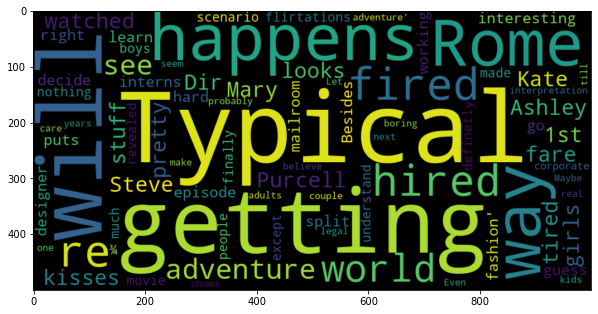

In [63]:
plt.figure(figsize=(10,10))
positive_text=norm_train_reviews[1]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)
plt.imshow(positive_words,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

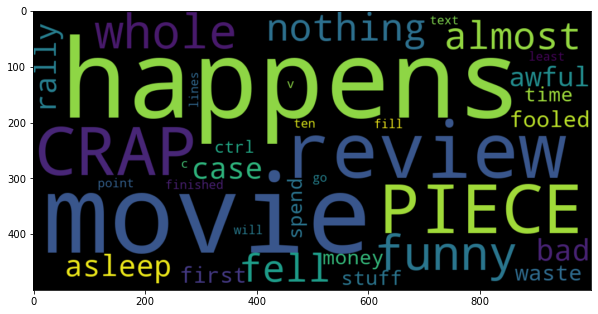

In [64]:
plt.figure(figsize=(10,10))
negative_text=norm_train_reviews[8]
WC=WordCloud(width=1000,height=500,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)
plt.imshow(negative_words,interpolation='bilinear')
plt.show